### Data Loading

In [711]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy

from epftoolbox.evaluation import MAE, sMAPE

In [712]:
%run C:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\data\_datasets.py
%run C:\Users\CTLGNN00C\Documents\GitHub\epftoolbox\epftoolbox\models\_lear.py

In [713]:
path = "C:/Users/CTLGNN00C/Documents/ENERGY/Progetto MGP"

In [714]:
train_df, test_df = read_data(path, dataset = "FR") # Grouped dataframes (by date)

## Pre-processing

In [715]:
# Check indice iniziale
if train_df.index[0].hour != 0 or test_df.index[0].hour != 0:
    print('Problem with the index')

In [716]:
# Numero di variabili esogene (tutte tranne il prezzo)
n_exogenous_inputs = len(train_df.columns) - 1

In [717]:
# Features: 96 prices + n_exogenous * (24 * 3 exogeneous) + 7 weekday dummies
# Price lags: D-1, D-2, D-3, D-7
# Exogeneous inputs lags: D, D-1, D-7

n_features = 96 + 7 + n_exogenous_inputs * 72

In [718]:
# Dato che compare il lag D-7 dobbiamo scartare almeno la prima settimana

indexTrain = train_df.loc[train_df.index[0] + pd.Timedelta(weeks=1):].index

In [719]:
# Se impostato su None prende tutti i valori possibili per la previsione, in caso contrario solo i valori da predire per un giorno specifico
date_test = None

if date_test is None:
    indexTest = test_df.loc[test_df.index[0] + pd.Timedelta(weeks=1):].index
else:
    indexTest = test_df.loc[date_test:date_test + pd.Timedelta(hours=23)].index


In [720]:
# Seleziono un timestamp ogni 24 -> un valore giornaliero
predDatesTrain = indexTrain.round('1h')[::24]
predDatesTest = indexTest.round('1h')[::24]

In [721]:
# Creiamo due datasets con tante colonne quante ore del giorno

indexTrain = pd.DataFrame(index=predDatesTrain, columns=['h' + str(hour) for hour in range(24)])
indexTest = pd.DataFrame(index=predDatesTest, columns=['h' + str(hour) for hour in range(24)])
for hour in range(24):
    indexTrain.loc[:, 'h' + str(hour)] = indexTrain.index + pd.Timedelta(hours=hour)
    indexTest.loc[:, 'h' + str(hour)] = indexTest.index + pd.Timedelta(hours=hour)

In [722]:
# Preallocamento della memoria
X_train = np.zeros([indexTrain.shape[0], n_features])
X_test = np.zeros([indexTest.shape[0], n_features])
Y_train = np.zeros([indexTrain.shape[0], 24])

In [723]:
feature_index = 0

In [724]:
# Aggiungere i prezzi storici nei giorni D-1, D-2, D-3 e D-7


for hour in range(24):
    # Lag
    for past_day in [1, 2, 3, 7]:

        # definiamo gli indici temporali utilizzando dataframes di appoggio
        pastIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)]) - pd.Timedelta(hours=24 * past_day)
        pastIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values) - pd.Timedelta(hours=24 * past_day)

        # Prezzi storici nei giorni passati all'ora h
        X_train[:, feature_index] = train_df.loc[pastIndexTrain, 'Price']
        X_test[:, feature_index] = test_df.loc[pastIndexTest, 'Price']
        feature_index += 1

In [725]:
X_train

array([[36.538, 25.206, 31.041, ...,  0.   ,  0.   ,  0.   ],
       [21.324, 36.538, 25.206, ...,  0.   ,  0.   ,  0.   ],
       [22.727, 21.324, 36.538, ...,  0.   ,  0.   ,  0.   ],
       ...,
       [48.76 , 43.36 , 49.95 , ...,  0.   ,  0.   ,  0.   ],
       [53.48 , 48.76 , 43.36 , ...,  0.   ,  0.   ,  0.   ],
       [38.8  , 53.48 , 48.76 , ...,  0.   ,  0.   ,  0.   ]])

In [726]:
# Variabili esogene nei giorni D, D-1,  D-7

for hour in range(24):
    for past_day in [1, 7]:
        
        for exog in range(1, n_exogenous_inputs + 1):

            # Definying the corresponding past time indexs using the auxiliary dataframses 
            pastIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values) - \
                pd.Timedelta(hours=24 * past_day)
            pastIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values) - \
                pd.Timedelta(hours=24 * past_day)

            # Including the exogenous input at day D-past_day and hour "h" 
            X_train[:, feature_index] = train_df.loc[pastIndexTrain, 'Exogenous ' + str(exog)]                    
            X_test[:, feature_index] = test_df.loc[pastIndexTest, 'Exogenous ' + str(exog)]
            feature_index += 1

    # For each of the exogenous inputs we include feature if feature selection indicates it
    for exog in range(1, n_exogenous_inputs + 1):
        
        # Definying the corresponding future time indexs using the auxiliary dataframses 
        futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
        futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

        # Including the exogenous input at day D and hour "h" 
        X_train[:, feature_index] = train_df.loc[futureIndexTrain, 'Exogenous ' + str(exog)]        
        X_test[:, feature_index] = test_df.loc[futureIndexTest, 'Exogenous ' + str(exog)] 
        feature_index += 1

In [727]:
# Aggiungiamo le variabily dummy

for dayofweek in range(7):
    X_train[indexTrain.index.dayofweek == dayofweek, feature_index] = 1
    X_test[indexTest.index.dayofweek == dayofweek, feature_index] = 1
    feature_index += 1

    # Estrazione dei valori predetti di y
    for hour in range(24):
        # Definizione degli indici di tempo all'ora h
        futureIndexTrain = pd.to_datetime(indexTrain.loc[:, 'h' + str(hour)].values)
        futureIndexTest = pd.to_datetime(indexTest.loc[:, 'h' + str(hour)].values)

        # Estrazione dei valori di Y basandoci sugli indici di tempo
        Y_train[:, hour] = train_df.loc[futureIndexTrain, 'Price']

In [728]:
# calibration_window = 3*365

# X_train = X_train[:calibration_window, :]
# Y_train = Y_train[:calibration_window, :]



## Model definition / Training / Prediction

In [729]:
model = LEAR()

model.recalibrate(X_train, Y_train)

In [730]:
X_test_pred = model.predict_days(X_test)

In [731]:
one_pred = model.recalibrate_predict(X_train, Y_train, X_test[8, :].reshape(1, -1))

## Test true / pred comparison

In [732]:
x_test_pred_df = pd.DataFrame(X_test_pred)

# x_test_df.set_index(indexTest.index, inplace=True)

In [733]:
test_prices_list  = []

true_prices = test_df['Price']

In [734]:
for i in range(0, len(true_prices),24):
    test_prices_list.append(np.array(true_prices[i:24+i]))

In [735]:
test_true_prices = np.vstack(test_prices_list)

In [736]:
x_test_true_prices_df = pd.DataFrame(test_true_prices)

In [737]:
x_test_pred_df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,23.539963,17.837009,13.234855,8.126490,3.765183,-0.754207,-2.074301,-0.650518,-1.857361,9.474097,...,21.103219,16.131926,14.974693,28.788154,39.636007,43.432880,41.218068,34.155752,37.912296,34.949618
1,28.070165,26.077792,23.891890,18.715513,16.566679,24.268646,36.115926,49.102775,48.997061,48.059732,...,43.035988,40.312426,41.181237,47.419470,54.813374,54.384609,48.714327,40.201399,39.657965,37.550438
2,31.252602,28.897086,26.651210,22.135732,19.937673,25.054730,34.939861,45.430612,47.414930,46.228526,...,39.359818,38.347916,40.313466,45.749407,51.652863,50.905382,45.086835,37.457330,38.680478,36.218294
3,27.769458,25.374455,22.605965,18.747680,17.010735,21.543459,33.557562,45.735891,48.070456,47.374255,...,39.685950,37.698780,39.014252,44.337669,50.144927,49.095637,43.416206,36.289595,36.268226,33.959079
4,34.057852,30.470954,27.594375,22.044919,20.238946,24.742330,36.001683,46.824004,48.711414,46.444682,...,38.305927,37.765409,39.011703,45.246854,50.635326,50.272414,44.091174,35.913470,37.157316,36.367391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,46.820864,43.045075,37.348137,31.335896,30.662662,37.107820,43.832628,53.892766,57.020565,57.809702,...,50.625158,48.627521,49.500537,62.650692,67.047153,63.510646,56.005422,52.790441,52.899073,49.907360
717,47.818274,47.280386,44.102924,38.480369,37.012611,42.923473,47.832016,54.529308,58.433653,59.282314,...,53.329027,52.168378,53.269107,64.345846,68.717824,67.776375,59.321411,52.890016,52.301403,49.052173
718,44.009493,44.183186,41.647081,35.817975,34.508870,40.753924,47.334851,55.451395,60.173679,58.182257,...,56.028693,55.280992,55.666150,67.575800,68.620551,67.647150,58.745607,54.559557,54.114448,51.438687
719,52.322847,49.106581,43.021910,42.048422,41.834033,41.781553,49.420155,58.040429,60.745862,62.194378,...,54.036773,51.068291,52.598628,63.955545,67.756465,66.188670,62.302340,54.000087,56.346610,53.277205


In [738]:
X_test.shape

(721, 247)

In [739]:
start_test_date = test_df.index[24*7] 
end_test_date = start_test_date + pd.Timedelta(days=X_test.shape[0]-1)
prediction_dates = pd.date_range(start=start_test_date, end=end_test_date, freq="D")

In [740]:
# I primi sette giorni vanno eliminati in quanto non considerabili nelle predizioni (ci serve il lag)
x_test_true_prices_df = x_test_true_prices_df.iloc[7:, :]

In [743]:
x_test_true_prices_df.set_index(prediction_dates, inplace=True)
x_test_pred_df.set_index(prediction_dates, inplace=True)

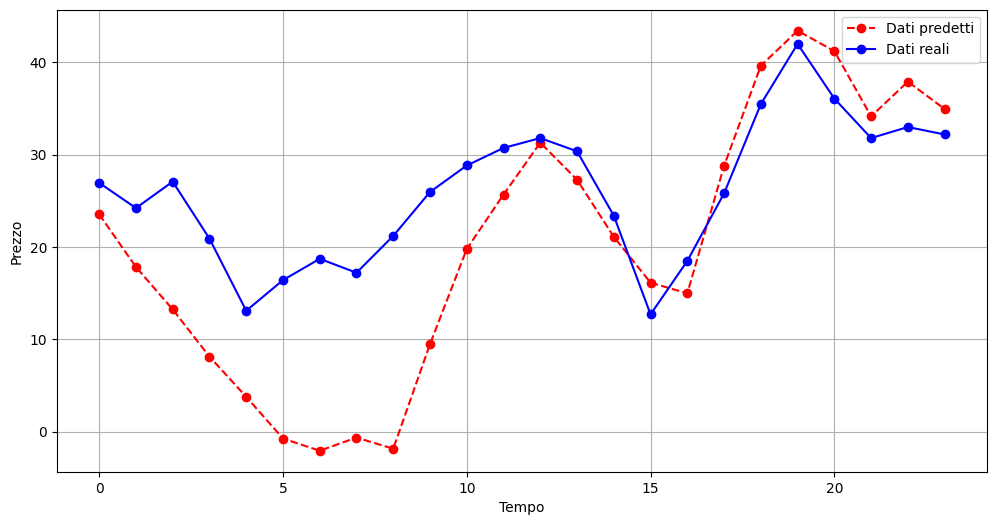

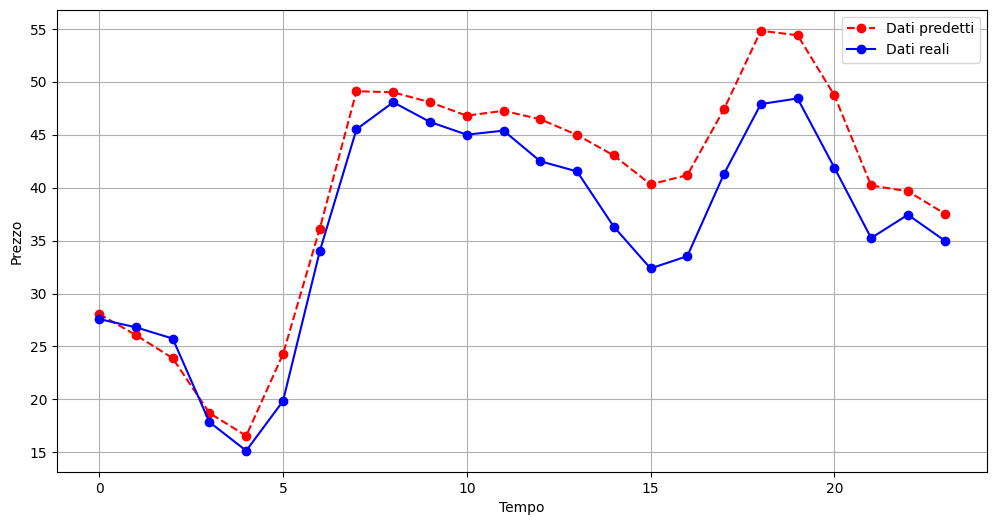

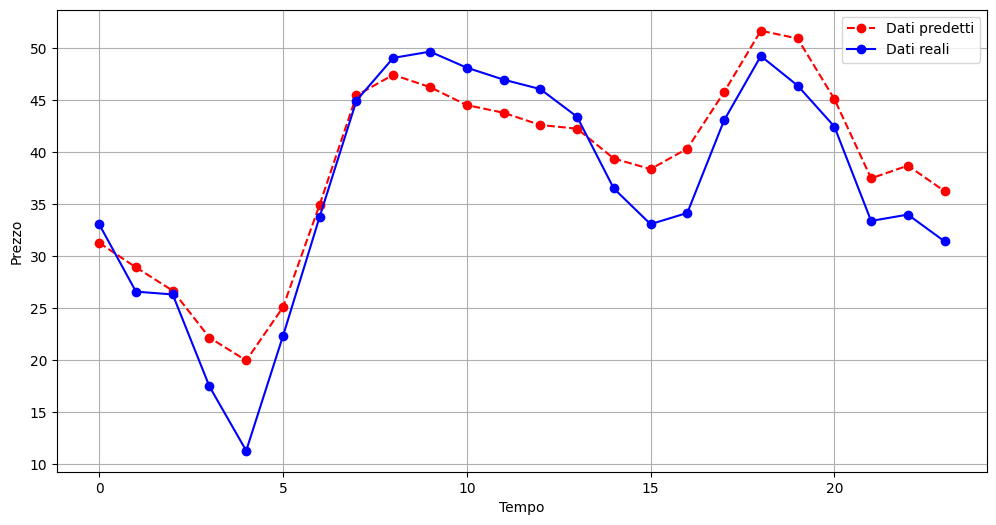

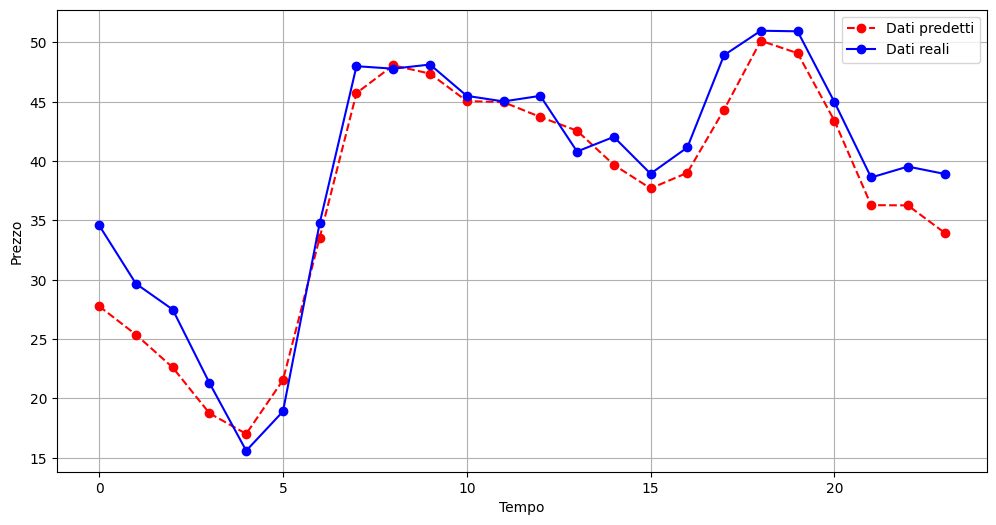

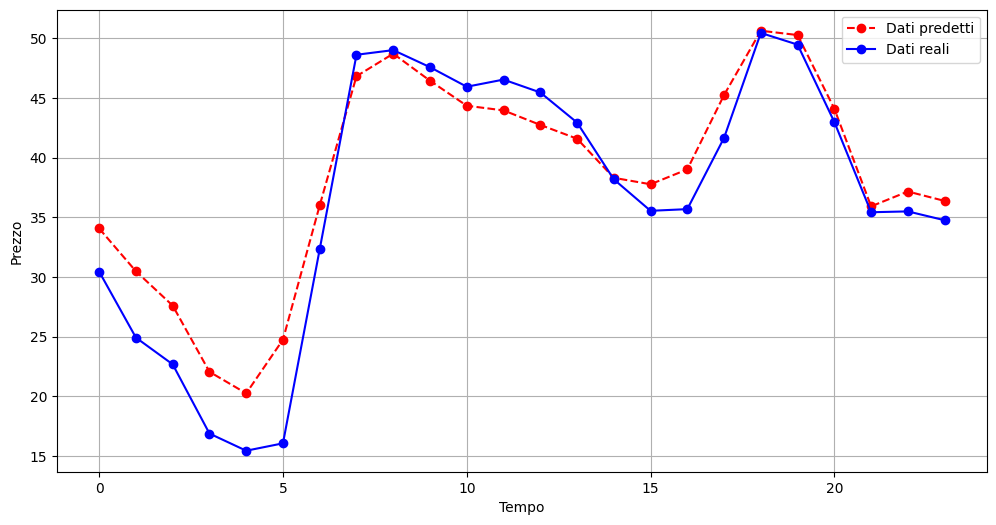

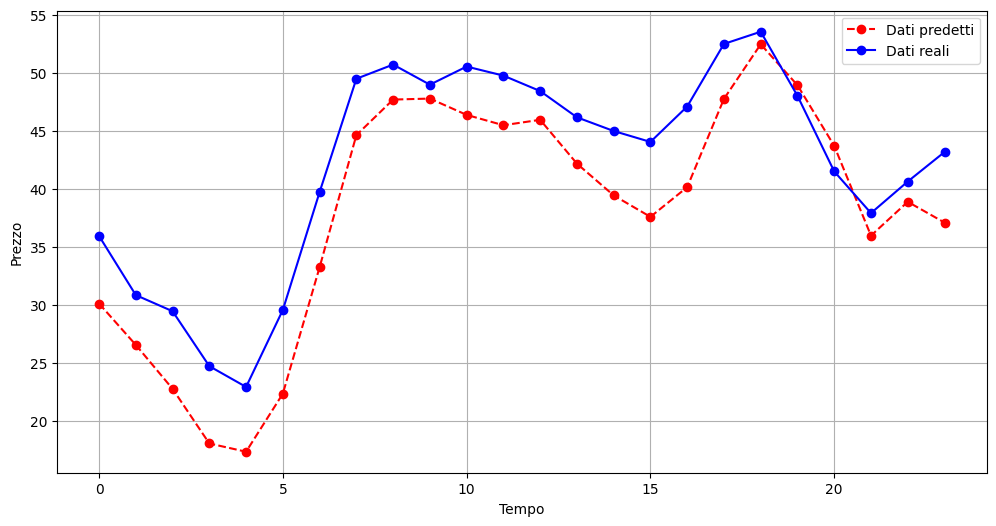

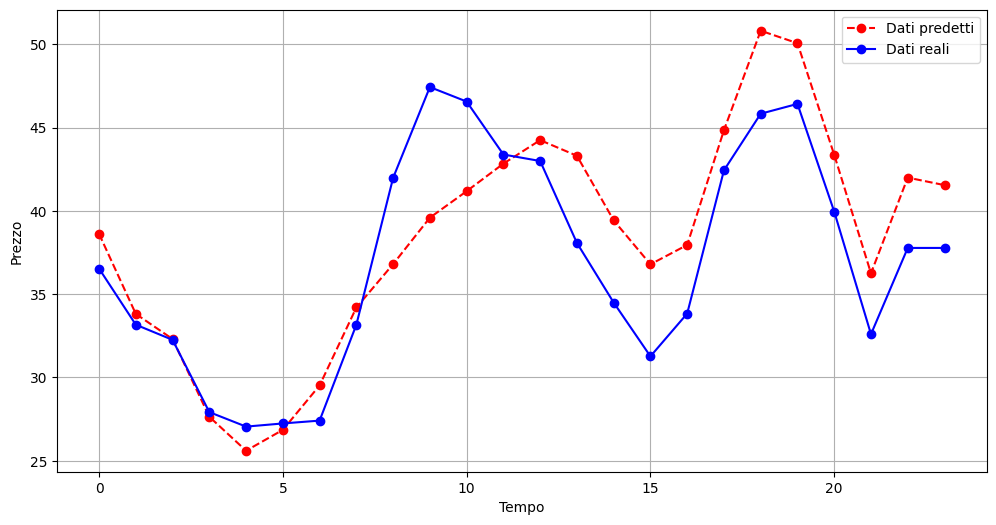

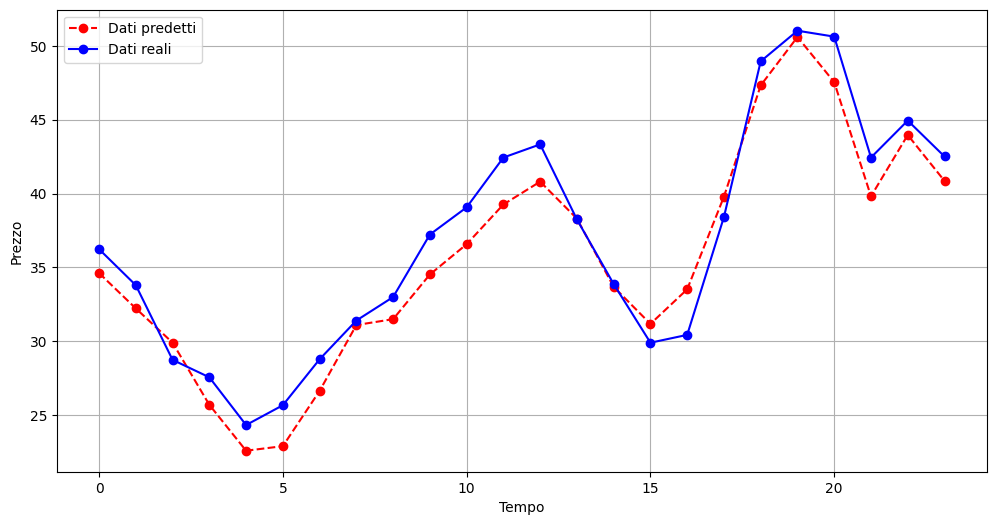

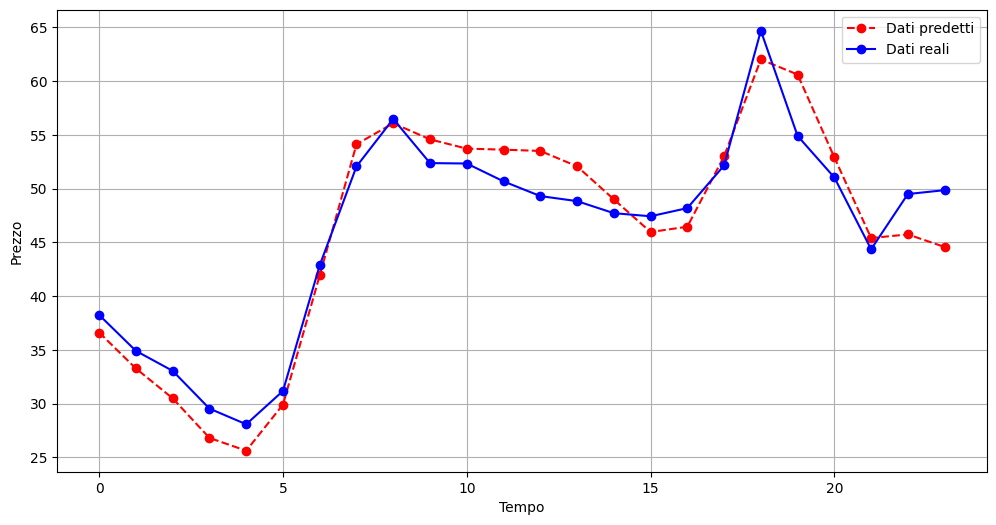

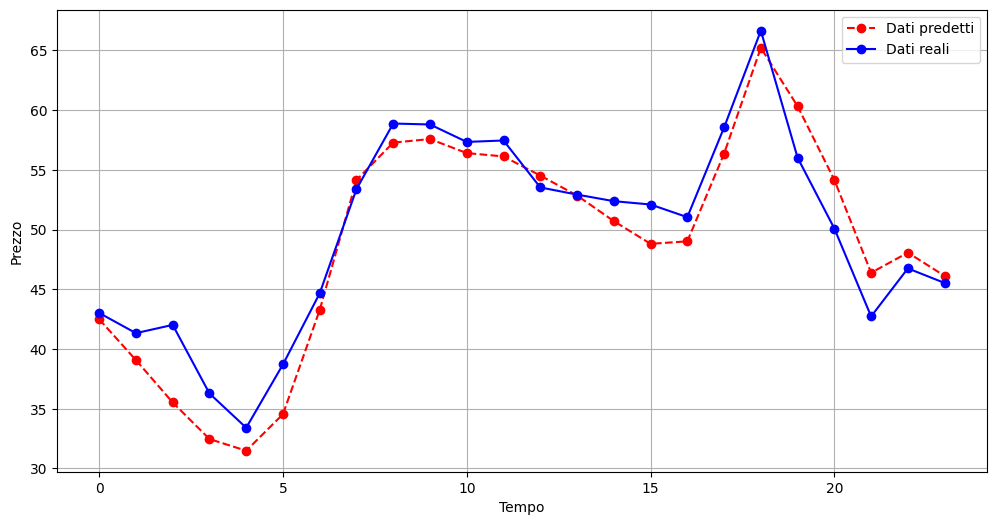

In [746]:
time_index = np.arange(24)

for i in range(0, 10):

    plt.figure(figsize=(12, 6))

    plt.plot(time_index, x_test_pred_df.iloc[i, :], label='Dati predetti', color='red', linestyle='--', marker='o')
    plt.plot(time_index, x_test_true_prices_df.iloc[i, :], label='Dati reali', color='blue', linestyle='-', marker='o')

    plt.xlabel('Tempo')
    plt.ylabel('Prezzo')
    plt.legend()
    plt.grid(True)
    plt.show()


## Metrics computation

In [609]:
MAE_LEAR = MAE(np.hstack(np.array(x_test_true_prices_df)), np.hstack(np.array(x_test_pred_df)))
sMAPE_LEAR = sMAPE(np.hstack(np.array(x_test_true_prices_df)), np.hstack(np.array(x_test_pred_df)))

In [610]:
MAE_LEAR, sMAPE_LEAR

(4.97843990666375, 0.16654050427144104)

In [611]:
from sklearn.metrics import mean_absolute_percentage_error

MAPE_LEAR = mean_absolute_percentage_error(np.hstack(np.array(x_test_true_prices_df)), np.hstack(np.array(x_test_pred_df)))
MAPE_LEAR

0.18092955296430757

In [466]:
# one_pred = model.predict(X_test[7, :].reshape(1, -1))